In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/dev/shm/train_data.csv')
df_lab = pd.read_csv('/dev/shm/train_labels.csv')
df_test = pd.read_csv('/dev/shm/test_data.csv')

## Data Exploration

In [3]:
print(f'Rows per customer: {df.shape[0] / df.customer_ID.unique().shape[0]}',)

Rows per customer: 12.053376130116165


In [4]:
df_with_labels = df.set_index('customer_ID').join(df_lab.set_index('customer_ID'))

In [5]:
len(df_with_labels)

5531451

### Missing Values

In [6]:
nan_per_column = df_with_labels.isna().sum()

In [7]:
nan_percentage = nan_per_column / len(df_with_labels)
nan_percentage = nan_percentage[nan_percentage != 0]

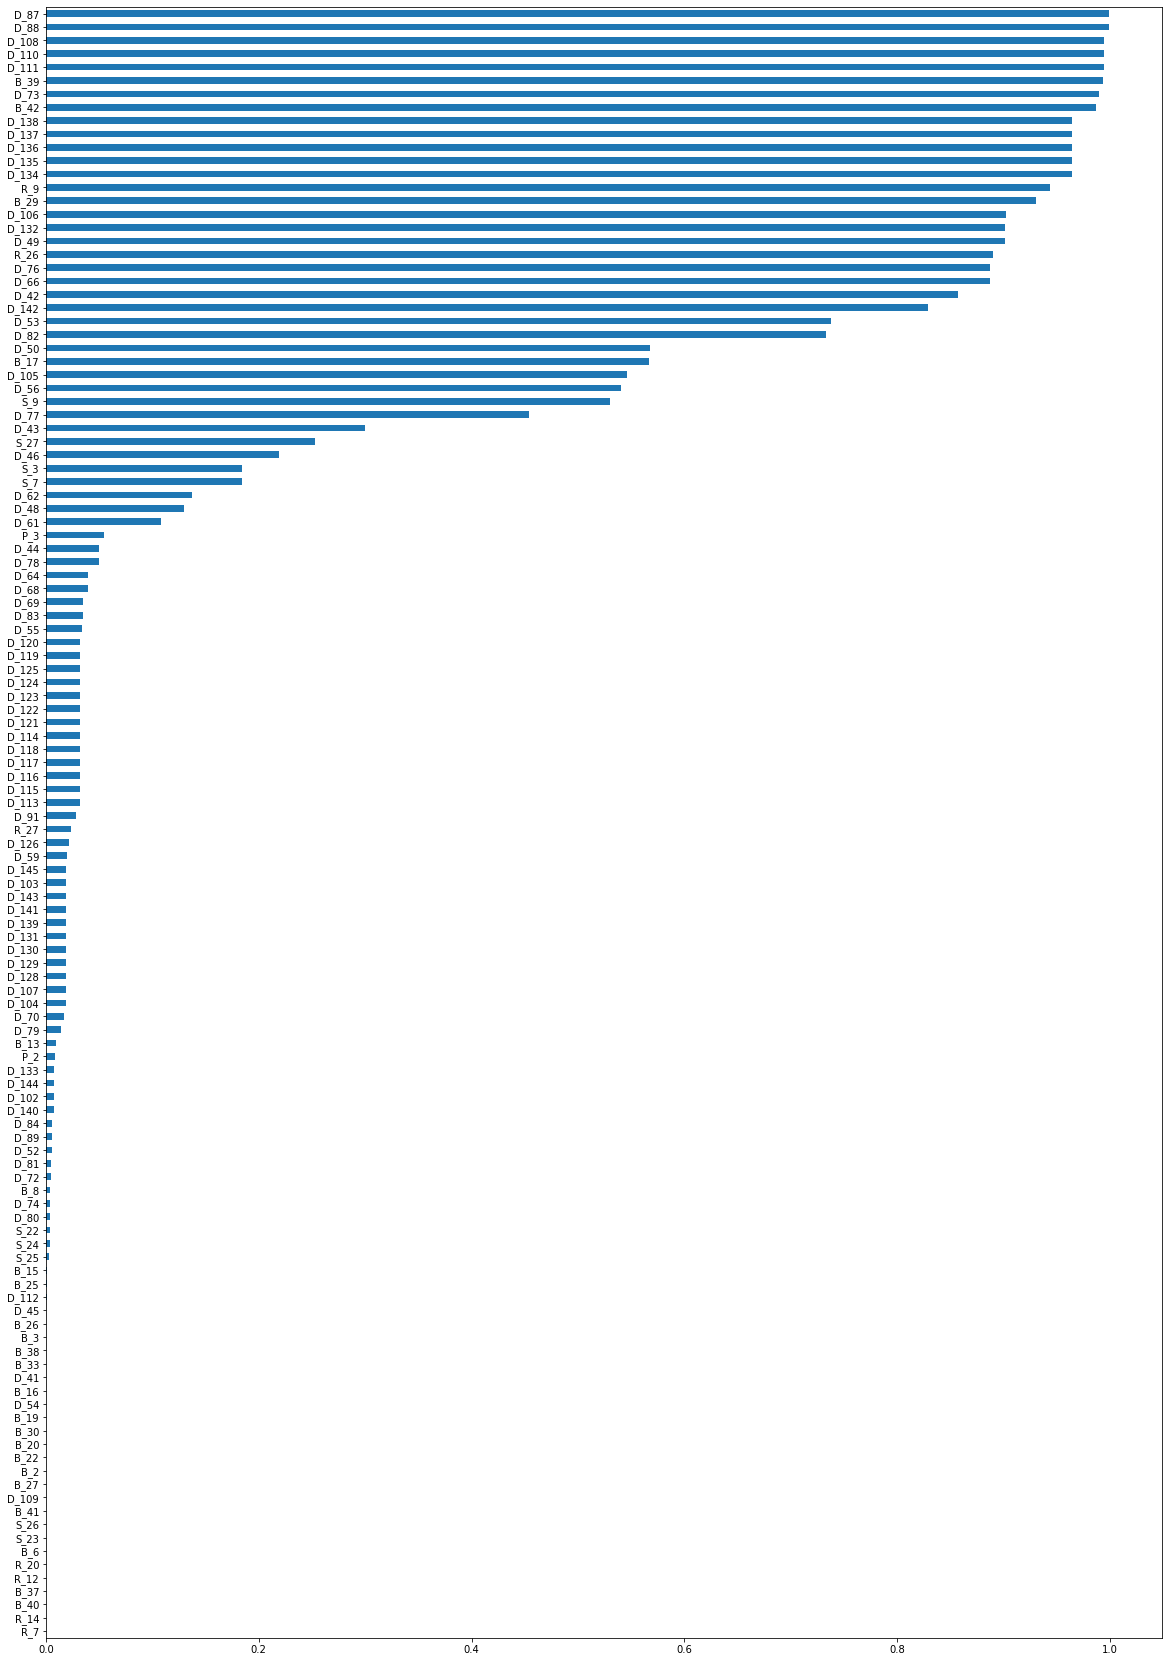

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
nan_percentage.sort_values().plot(kind='barh')
fig.set_size_inches(20, 30)

### Categorical Variables

In [9]:
cat_vars =  ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

## Plain Catboost

In [10]:
from catboost import CatBoostClassifier, Pool
import numpy as np

In [11]:
labels = df_with_labels[['target']]

In [12]:
cols = df_with_labels.columns.tolist()
cols.remove('target')
cols.remove('S_2') # Statement Date?
data = df_with_labels[cols].copy()

In [13]:
cat_dtypes = data.dtypes[cat_vars]

In [14]:
data[cat_vars] = data[cat_vars].where(~data[cat_vars].isna(), 0)

In [15]:
data = data.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})

In [16]:
data_no_nan = data.replace(np.nan, "")

In [17]:
pool = Pool(data_no_nan, labels, cat_vars)

In [18]:
model = CatBoostClassifier(iterations=1000)

In [ ]:
model.fit(pool)

Learning rate set to 0.408438
0:	learn: 0.4051070	total: 2.17s	remaining: 36m 13s
1:	learn: 0.3430078	total: 4.13s	remaining: 34m 19s
2:	learn: 0.3136562	total: 5.88s	remaining: 32m 35s
3:	learn: 0.3034181	total: 7.69s	remaining: 31m 55s
4:	learn: 0.2980180	total: 9.4s	remaining: 31m 10s
5:	learn: 0.2942170	total: 11.1s	remaining: 30m 45s
6:	learn: 0.2907092	total: 13s	remaining: 30m 37s
7:	learn: 0.2888219	total: 14.8s	remaining: 30m 35s
8:	learn: 0.2868002	total: 16.4s	remaining: 30m 7s
9:	learn: 0.2855879	total: 18.2s	remaining: 30m 6s
10:	learn: 0.2843995	total: 20s	remaining: 29m 58s
11:	learn: 0.2830686	total: 21.8s	remaining: 29m 52s
12:	learn: 0.2823721	total: 23.5s	remaining: 29m 42s
13:	learn: 0.2815521	total: 25.3s	remaining: 29m 39s
14:	learn: 0.2809022	total: 27.1s	remaining: 29m 38s
15:	learn: 0.2799597	total: 28.9s	remaining: 29m 40s
16:	learn: 0.2792380	total: 30.5s	remaining: 29m 24s
17:	learn: 0.2787119	total: 32s	remaining: 29m 6s
18:	learn: 0.2779691	total: 33.8s	re

In [ ]:
df_test.head()

In [ ]:
df_test = df_test.set_index('customer_ID')
cols = df_test.columns.tolist()
cols.remove('S_2') # Statement Date?
df_test = df_test[cols].copy()

In [ ]:
cat_dtypes = df_test.dtypes[cat_vars]
df_test[cat_vars] = df_test[cat_vars].where(~df_test[cat_vars].isna(), 0)
df_test = df_test.astype({k: np.int32 for k in cat_dtypes[cat_dtypes == np.float64].keys()})
df_test_no_nan = df_test.replace(np.nan, "")

In [ ]:
preds = model.predict_proba(df_test_no_nan)[:,1]

In [ ]:
preds = model.predict(df_test_no_nan)

In [ ]:
preds

In [ ]:
df_preds = df_test_no_nan.assign(p=preds)

In [ ]:
a=df_preds['p'].reset_index()

In [ ]:
a.groupby('customer_ID').mean().rename(columns={"p":"prediction"}).to_csv('preds_longtraining.csv')